# Weighted Voronoi Stippling

[`video`](https://www.youtube.com/watch?v=Bxdt6T_1qgc)

[`Delaunay triangulation`](https://zh.wikipedia.org/zh-tw/%E5%BE%B7%E5%8B%9E%E5%85%A7%E4%B8%89%E8%A7%92%E5%89%96%E5%88%86)

[`Reference`](https://dahtah.github.io/imager/stippling.html)

[`github`](https://github.com/matthras/weighted-voronoi-stippling-rougier2017)

[`tsp-art`](https://github.com/matthras/tsp-art-python)

[`Weighted Voronoi Stippling`](https://www.cs.ubc.ca/labs/imager/tr/2002/secord2002b/secord.2002b.pdf)

[`Feature-guided Image Stippling`](https://www.umsl.edu/~kangh/Papers/kang_egsr08.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
import time
import scipy
import scipy.spatial

In [2]:
def show_(src, s=5, pr=1.5):  # show the image
    img = src.copy()
    
    plt.figure(figsize=(s, s))
    plt.xticks([])
    plt.yticks([])
    
    if np.dtype(img.dtype).kind == 'f': # 浮點數處理
        pr_low = np.percentile(img, pr)
        pr_high = np.percentile(img, 100 - pr)
        print(f'min: {img.min():.2f}, PR{pr}: {pr_low:.2f}, PR{100-pr}: {pr_high:.2f}, max: {img.max():.2f}')
        
        img = img.clip(pr_low, pr_high)
        plt.imshow(img)
    
    else:
        img = img.clip(0, 255).astype(np.uint8)
        if img.ndim == 3:  # color image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV 的色彩空間 BRG
            plt.imshow(img, vmin=0, vmax=255)
        else:  # gray image
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            
    plt.show()

    
def get_coor_arr(n, D):
    w = D.shape[1]
    arr = (255 - D[::-1]).flatten()
    arr = arr.astype(np.float64) / arr.sum()
    random_lst = np.random.choice(np.arange(D.size), n, p=arr)
    y = random_lst // w
    x = random_lst % w
    coor = np.vstack((x, y)).T
    coor = coor + np.random.uniform(size=coor.shape) # add a random value(0 ~ 1)
    
    return coor

def get_mass(polygon:np.array): # shape (n, 2)
    polygon2 = np.roll(polygon, -1, axis=0)

    # Compute signed area of each triangle
    signed_areas = 0.5 * np.cross(polygon, polygon2)
    # Compute centroid of each triangle
    centroids = (polygon + polygon2) / 3.0
    # Get average of those centroids, weighted by the signed areas.
    mass = np.average(centroids, axis=0, weights=signed_areas)
    
    return mass

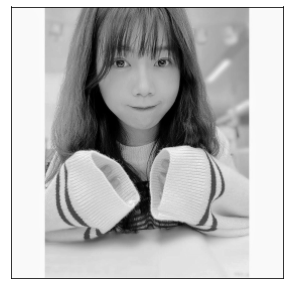

In [3]:
img = cv2.imread(f'Hanne.jpg', 0)[:-3]
img = cv2.resize(img, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
show_(img, 5)

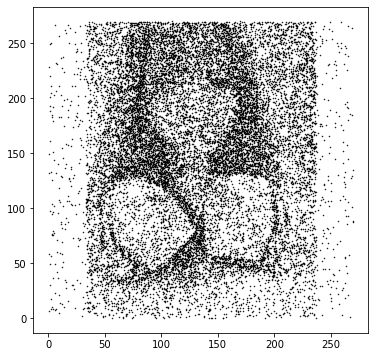

In [4]:
coor = get_coor_arr(20000, img)
plt.figure(figsize=(6, 6))
plt.plot(coor.T[0], coor.T[1], 'ok', ms=0.5)

### [`scipy.spatial.Voronoi`](https://www.cnblogs.com/ttweixiao-IT-program/p/14374270.html)

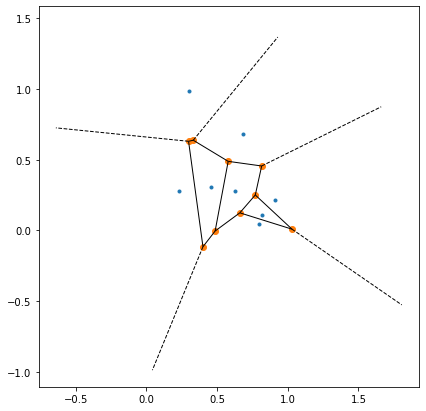

In [5]:
np.random.seed(35)
pts = np.random.uniform(size=(8, 2))
vor = scipy.spatial.Voronoi(pts, furthest_site=False, incremental=False)

fig = scipy.spatial.voronoi_plot_2d(vor, show_points=True, show_vertices=True)
fig.set_figheight(7)
fig.set_figwidth(7)
plt.axis('square')
# plt.xlim((0, 1))
# plt.ylim((0, 1))
plt.show()

#### 原始點位 (blue points) 也是餵進去的點位

In [6]:
print(np.all(pts == vor.points))
print(vor.points.shape)
vor.points

True
(8, 2)


array([[0.45805495, 0.30834961],
       [0.23148705, 0.27742455],
       [0.81723481, 0.11134664],
       [0.62643723, 0.27678789],
       [0.68217467, 0.67897078],
       [0.79671742, 0.04580216],
       [0.91259827, 0.21381599],
       [0.3036373 , 0.98906362]])

#### vertices (orange points) 焦點數 原始點彼此的中垂線分割的焦點

In [7]:
print(vor.vertices.shape)
vor.vertices

(9, 2)


array([[ 1.03029889,  0.00866765],
       [ 0.298746  ,  0.63008248],
       [ 0.33203062,  0.63763298],
       [ 0.40052129, -0.11555932],
       [ 0.77062509,  0.25033398],
       [ 0.81577385,  0.45550193],
       [ 0.57893868,  0.48832428],
       [ 0.66124695,  0.12419201],
       [ 0.48654523, -0.00459621]])

#### 原始點位對應的區域 key Index `point_region`
#### 區域index 對應中垂線焦點列表 `regions`

In [8]:
print(vor.npoints)
print(len(vor.point_region))
print(len(vor.regions))

print(f'{vor.point_region = }')
print(f'{vor.regions = }')

print('--------------------------------------------------')
for i in vor.point_region:
    print(vor.regions[i])


8
8
9
vor.point_region = array([7, 2, 4, 3, 6, 8, 5, 1], dtype=int64)
vor.regions = [[], [2, -1, 1], [3, -1, 1], [8, 6, 5, 4, 7], [7, 0, 4], [5, -1, 0, 4], [6, 2, -1, 5], [8, 3, 1, 2, 6], [8, 3, -1, 0, 7]]
--------------------------------------------------
[8, 3, 1, 2, 6]
[3, -1, 1]
[7, 0, 4]
[8, 6, 5, 4, 7]
[6, 2, -1, 5]
[8, 3, -1, 0, 7]
[5, -1, 0, 4]
[2, -1, 1]


0
[8, 3, 1, 2, 6]
[8, 3, 1, 2, 6]


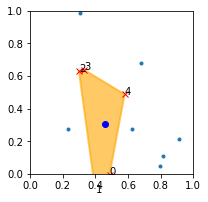

--------------------------------------------------
1
[3, -1, 1]
[3, 1]


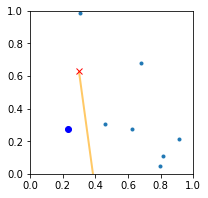

--------------------------------------------------
2
[7, 0, 4]
[7, 0, 4]


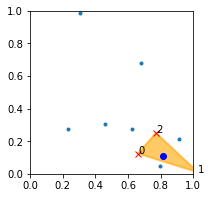

--------------------------------------------------
3
[8, 6, 5, 4, 7]
[8, 6, 5, 4, 7]


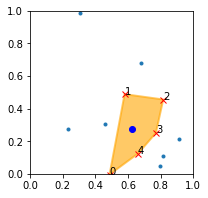

--------------------------------------------------
4
[6, 2, -1, 5]
[6, 2, 5]


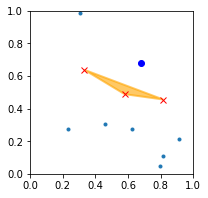

--------------------------------------------------
5
[8, 3, -1, 0, 7]
[8, 3, 0, 7]


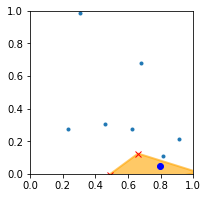

--------------------------------------------------
6
[5, -1, 0, 4]
[5, 0, 4]


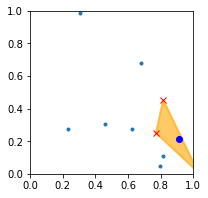

--------------------------------------------------
7
[2, -1, 1]
[2, 1]


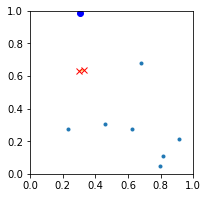

--------------------------------------------------


In [9]:
for i in range(vor.npoints):
    print(i)
    plt.figure(figsize=(3, 3))
    plt.plot(pts[:, 0], pts[:, 1], '.')
    plt.plot(pts[i, 0], pts[i, 1], 'bo')
    ass = vor.regions[vor.point_region[i]].copy()
    print(ass)
    
    if -1 in ass:
        ass.remove(-1)
    else:
        for i in range(len(ass)):
            plt.text(vor.vertices[ass[i]][0], vor.vertices[ass[i]][1], f'{i}')
    
    print(ass)
    
    ary = vor.vertices[ass]
    plt.fill(ary[:, 0], ary[:, 1], alpha=0.6, linestyle='-', lw=2, color='orange')
    plt.plot(ary[:, 0], ary[:, 1], 'rx')
#     plt.plot(ary[:, 0], ary[:, 1])

    plt.axis('square')
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.show()
    
    print('--------------------------------------------------')
    

### 影像的分割線:
- 由那兩個原始點位index組的中垂線 `ridge_points`
- 由那兩個焦點(`vertices`) index組的直線`ridge_vertices`

(-0.06357292882360767,
 1.4568685765560592,
 -0.4622669044120706,
 1.0581746009675963)

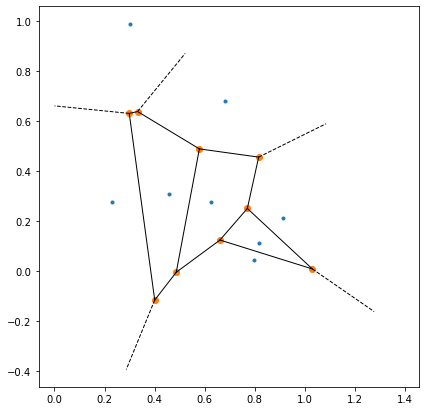

In [10]:
plt.figure(figsize=(7, 7))
plt.plot(vor.points[:, 0], vor.points[:, 1], '.', markersize=None)
plt.plot(vor.vertices[:, 0], vor.vertices[:, 1], 'o')
center = vor.points.mean(axis=0)
# ptp_bound = np.ptp(vor.points, axis=0)

finite_segments = []
infinite_segments = []
for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
    simplex = np.asarray(simplex)
    
    if np.all(simplex >= 0):
        plt.plot(vor.vertices[simplex][:, 0], vor.vertices[simplex][:, 1], 'k-', lw=1)
        
    else:
        i = simplex[simplex >= 0][0]  # finite end Voronoi vertex
        t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
        t /= np.linalg.norm(t) # 單位向量 (兩個原始點位)
        n = np.array([-t[1], t[0]])  # normal 法向量 (中垂線的向量)

        midpoint = vor.points[pointidx].mean(axis=0) # 兩個原始點位的中間點
        direction = np.sign(np.dot(midpoint - center, n)) * n
        far_point = vor.vertices[i] + direction * 0.3
        
        line = np.array([vor.vertices[i], far_point])
        plt.plot(line[:, 0], line[:, 1], 'k--', lw=1)        
        
        
plt.axis('square')

## [Lloyd's algorithm](https://en.wikipedia.org/wiki/Lloyd%27s_algorithm) 
### [Polygon Mass](https://stackoverflow.com/questions/75699024/finding-the-centroid-of-a-polygon-in-python)

Centroid: [28.33333333 20.        ]


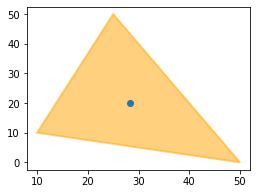

In [11]:
# polygon = np.array([(0, 0), (70, 0), (70,25), (45, 45), (45, 180), (95, 188), (95, 200), (-25, 200), (-25,188), (25,180), (25,45), (0, 25),], dtype=np.float64)
polygon = np.array([(10, 10), (50, 0), (25, 50)], dtype=np.float64)

# Same polygon, but with vertices cycled around. Now the polygon
# decomposes into triangles of the form origin-polygon[i]-polygon2[i]
polygon2 = np.roll(polygon, -1, axis=0)

# Compute signed area of each triangle
signed_areas = 0.5 * np.cross(polygon, polygon2)

# Compute centroid of each triangle
centroids = (polygon + polygon2) / 3.0

# Get average of those centroids, weighted by the signed areas.
centroid = np.average(centroids, axis=0, weights=signed_areas)

print("Centroid:", centroid)

plt.figure(figsize=(4, 3))
plt.fill(polygon[:, 0], polygon[:, 1], alpha=0.5, linestyle='-', lw=2, color='orange')
plt.plot([centroid[0]], [centroid[1]], 'o')


## Lloyd's algorithm (point move to mass)

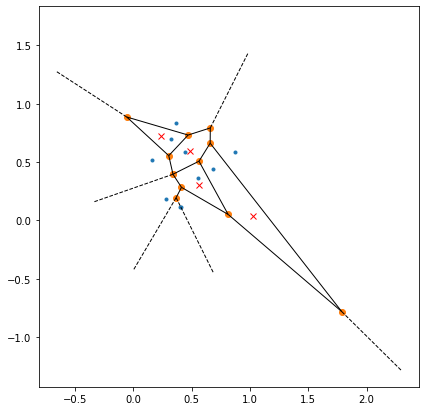

In [12]:
np.random.seed(25)
pts = np.random.uniform(size=(10, 2))
vor = scipy.spatial.Voronoi(pts)

fig = scipy.spatial.voronoi_plot_2d(vor, show_points=True, show_vertices=True)
fig.set_figheight(7)
fig.set_figwidth(7)
plt.axis('square')
# plt.xlim((0, 1))
# plt.ylim((0, 1))

mass_pts = []
for i in vor.point_region:
    vertice_lst = vor.regions[i]
    if -1 in vertice_lst:
        pass
    else:
        polygon = vor.vertices[vertice_lst]
        mass_pts.append(get_mass(polygon))

mass_pts = np.asarray(mass_pts)
plt.plot(mass_pts[:, 0], mass_pts[:, 1], 'rx')

plt.show()

- 可以發現部分無法組成多邊形, 無法計算質心 QQ

## Trick 
- 預設四角為錨點(padding一點)，除了四角的錨點, 其餘點不會產生非焦點的區域
    - [`Reference1`](https://stackoverflow.com/questions/52506681/constraining-the-domain-of-voronoi-vertices-generated-by-qhull)
    - [`Reference2`](https://douglasduhaime.com/posts/lloyd-iteration.html)
    - 質心超過邊界的情況直接定義於邊界. 四角往外padding一點點

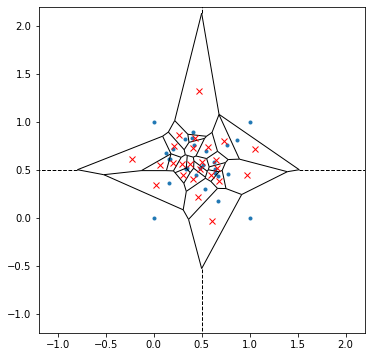

In [13]:
n = 25
pts = np.random.uniform(0.1, 0.9, size=(n, 2))
pts = np.vstack((pts, [[0, 0], [0, 1], [1, 0], [1, 1]]))
vor = scipy.spatial.Voronoi(pts)
fig = scipy.spatial.voronoi_plot_2d(vor, show_points=True, show_vertices=False)
fig.set_figheight(6)
fig.set_figwidth(6)
plt.axis('square')
pad = 1.2
plt.xlim((0 - pad, 1 + pad))
plt.ylim((0 - pad, 1 + pad))

mass_pts = []
for i in vor.point_region:
    vertice_lst = vor.regions[i]
    if -1 in vertice_lst:
        pass
    else:
        polygon = vor.vertices[vertice_lst]
        mass_pts.append(get_mass(polygon))

mass_pts = np.asarray(mass_pts)
plt.plot(mass_pts[:, 0], mass_pts[:, 1], 'rx')

plt.show()

### 9個點測試

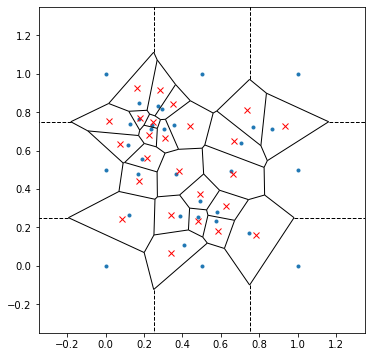

In [14]:
n = 25
pts = np.random.uniform(0.1, 0.9, size=(n, 2))
pts = np.vstack((pts, [[0, 0], [0, 0.5], [0, 1], [0.5, 0], [0.5, 1], [1, 0], [1, 0.5], [1, 1]]))
vor = scipy.spatial.Voronoi(pts)
fig = scipy.spatial.voronoi_plot_2d(vor, show_points=True, show_vertices=False)
fig.set_figheight(6)
fig.set_figwidth(6)
plt.axis('square')
pad = 0.35
plt.xlim((0 - pad, 1 + pad))
plt.ylim((0 - pad, 1 + pad))

mass_pts = []
for i in vor.point_region:
    vertice_lst = vor.regions[i]
    if -1 in vertice_lst:
        pass
    else:
        polygon = vor.vertices[vertice_lst]
        mass_pts.append(get_mass(polygon))

mass_pts = np.asarray(mass_pts)
plt.plot(mass_pts[:, 0], mass_pts[:, 1], 'rx')

plt.show()

# Go Go

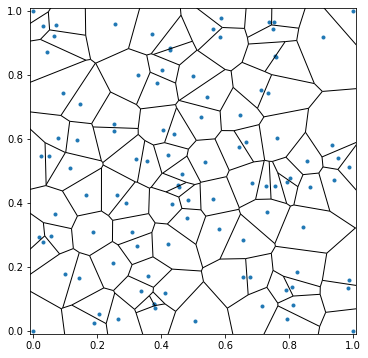

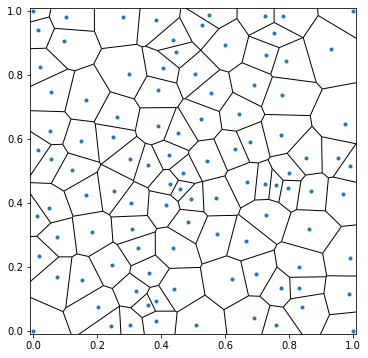

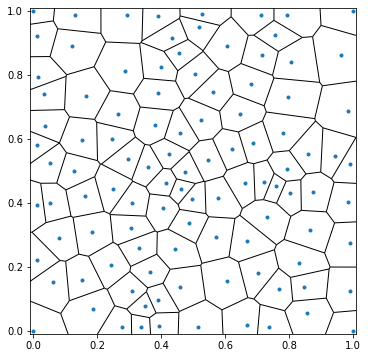

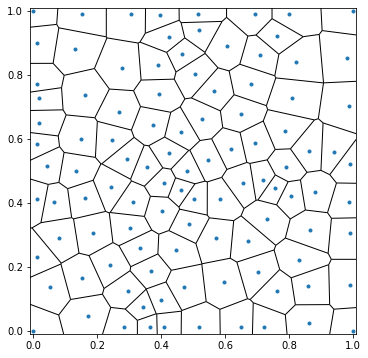

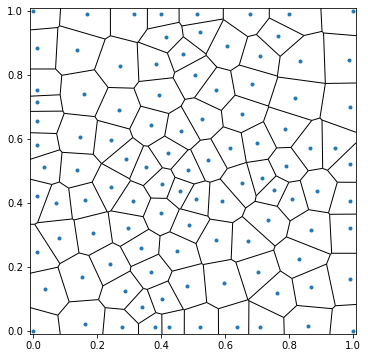

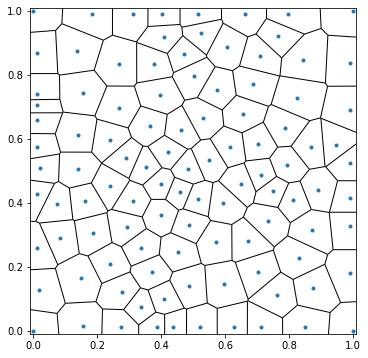

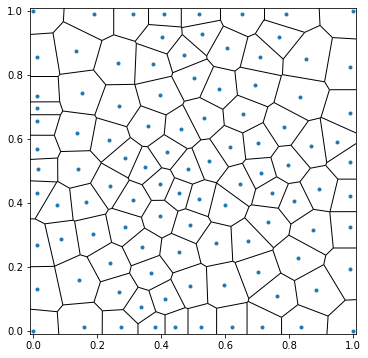

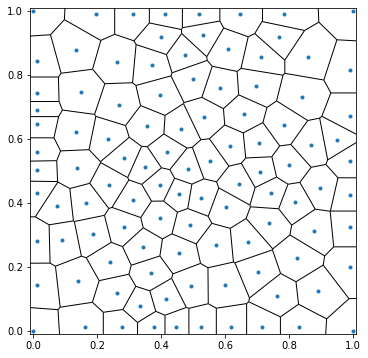

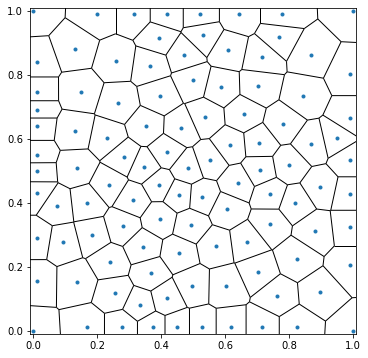

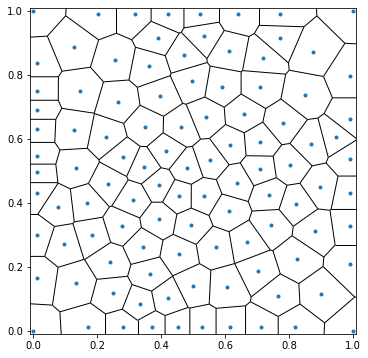

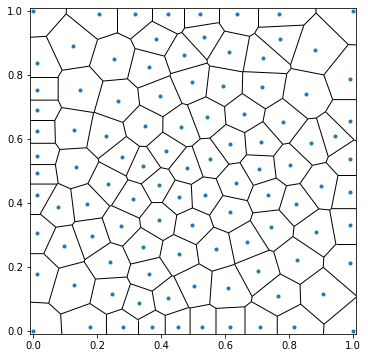

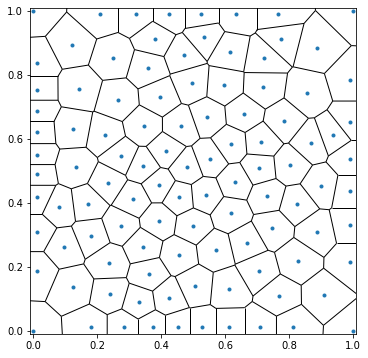

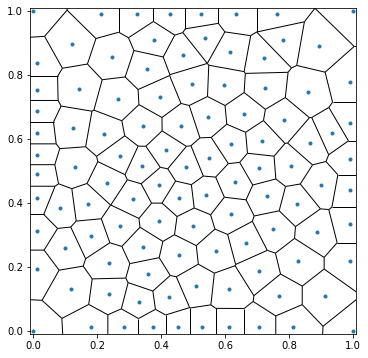

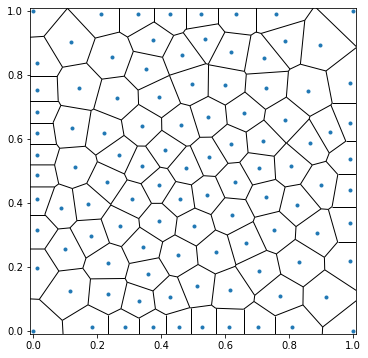

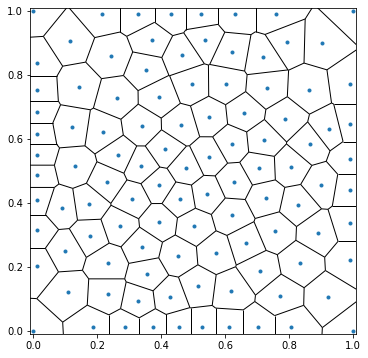

In [15]:
n = 100
move_rate = 0.7
border_min = 0.01
border_max = 0.99

pts = np.random.uniform(border_min, border_max, size=(n, 2))
pts = np.vstack((pts, [[0, 0], [0, 1], [1, 0], [1, 1]]))

for j in range(15):
    vor = scipy.spatial.Voronoi(pts)
    fig = scipy.spatial.voronoi_plot_2d(vor, show_points=True, show_vertices=False)
    fig.set_figheight(6)
    fig.set_figwidth(6)
    
#     plt.figure(figsize=(6, 6))
#     plt.plot(pts[:, 0], pts[:, 1], '.g')

    plt.axis('square')
    pad = 0.01
    plt.xlim((0 - pad, 1 + pad))
    plt.ylim((0 - pad, 1 + pad))
    
#     plt.plot(pts[:, 0], pts[:, 1], '.g')
    mass_pts = []
    mass_arr = []
    for i in range(n):
        vertice_lst = vor.regions[vor.point_region[i]]
        
        # 一定沒有-1
        polygon = vor.vertices[vertice_lst]
        mass = get_mass(polygon)
        mass_pts.append(mass.copy())
        mass = np.clip(get_mass(polygon), border_min, border_max) # 邊界條件
        mass_arr.append(mass.copy())
    
    # pts update
    v = np.array(mass_arr) - pts[:-4]
    pts[:-4] += (move_rate * v)
    
#     mass_pts = np.asarray(mass_pts)
#     plt.plot(mass_pts[:, 0], mass_pts[:, 1], 'rx')
#     mass_arr = np.asarray(mass_arr)
#     plt.plot(mass_arr[:, 0], mass_arr[:, 1], 'g+')
    
    plt.show()